# PySpice_EyePoint_CurveTracer
## часть проекта по восстановлению электронной схемы характериографом

## https://github.com/vasily84/PySpice_CurveTracer 


### Необходимы - python3.x, sklearn,PySpice

### необходимые библиотеки -
### PySpice - симуляция электронных схем из Python
https://pyspice.fabrice-salvaire.fr/ 

https://github.com/FabriceSalvaire/PySpice

### scikit-learn библиотека машинного обучения
https://scikit-learn.org/stable/index.html

## Как использовать?
### Необходимо задать рабочую папку программы в переменной FILEBASE_ROOT ( ячейка ниже). 
### Варианты запуска программы :

* Первый запуск - Папка задана, но не существует: программа создаст папку и скачает библиотеку spice компонентов из github, затем сгенерирует синтетические данные для схем, описанных в коде и построит модели машинного обучения для них. Для каждой модели создается отдельная папка внутри FILEBASE_ROOT. Туда же пишется её .pickle образ. При последующих запусках модели будут подгружаться с диска.


* Второй и прочие запуски - (папка FILEBASE_ROOT содержит библиотеку spice компонентов и дополнительные папки с обученными моделями) обученные модели загружаются с диска.


* При необходимости переобучить модель - можно удалить файл модели .pickle из ее подпапки или всю её подпапку - при следующем запуске ноутбука модель будет перетренирована.


* При необходимости перенести ноутбук целиком на другой компьютер можно скопировать папку FILEBASE_ROOT и указать правильные пути к ней, но следует помнить о возможной несовместимости .pickle объектов для разных версий питона и библиотек.

### Код написан последовательно сверху вниз-
### для тестирования и исследовательских целей удобнее всего запускать ноутбук целиком Menu->Kernel->Restart & Run All, помещая необходимый дополнительный код в самые нижние ячейки ноутбука, и затем дописывая и запуская ячейки


In [1]:
FILEBASE_ROOT = 'E:\EyePoint' # путь к рабочей папке программы

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
from sklearn import __version__ as sk_version
from scipy.signal import resample

import PySpice
import PySpice.Logging.Logging as Logging
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Unit import *

import os
import uuid
import random
import requests
import zipfile

logger = Logging.setup_logging()
PySpice.show_version()

print('sklearn version '+sk_version)

Circuit_Set = set() # set of all availible curcuits 

PySpice Version 1.4.3
sklearn version 1.0.2


### проверяем пути к рабочей папке, при необходимости подгружаем spice библиотеки компонентов и обученные модели с github

In [3]:
def download_and_unzip(filePath):
    print('downloading started..')
                       
    url = 'https://github.com/vasily84/PySpice_CurveTracer/raw/main/spice_library.zip'
    # Downloading the file by sending the request to the URL
    req = requests.get(url)

    zipName = os.path.join(filePath,'temp.zip')
    print('from '+str(url)+'\ndownloaded '+str(len(req.content))+' bytes')
    
    # Writing the file to the local file system
    with open(zipName,'wb') as output_file:
        output_file.write(req.content)
    print('downloading completed, UnZip started..')
    
    # unzip 
    with zipfile.ZipFile(zipName, 'r') as zip_ref:
        zip_ref.extractall(filePath)
        
    os.remove(zipName)
    print('UnZip completed..')
    
    
# проверяем пути к рабочей папке,
# при необходимости подгружаем spice библиотеки компонентов
# и обученные модели с github
if not os.path.exists(FILEBASE_ROOT):
    os.makedirs(FILEBASE_ROOT)
    download_and_unzip(FILEBASE_ROOT)

print('\nsimulation dataset on:\n'+FILEBASE_ROOT)

libraries_path = os.path.join(FILEBASE_ROOT,'spice_library')
print('\nspice models library on:\n'+libraries_path)
spice_library = SpiceLibrary(libraries_path)
print(spice_library['1N4148'])


simulation dataset on:
E:\EyePoint

spice models library on:
E:\EyePoint\spice_library
E:\EyePoint\spice_library\diode\switching\1N4148.lib


### код CreateCVC базируется на библиотеке MySpice
https://github.com/LukyanovM/MySpice

используем эту библиотеку, ибо она максимально близко имитирует прибор
EyePoint https://eyepoint.physlab.ru/ru/

In [4]:
import math
import numpy

class CurveTracer_Settings():
    """ EyePoint hardware settings struct"""
    def __init__(self,F=10_000,V=3.3,Rcs=0,SNR=40.0,lendata=64,cycle=3):
        self.F = F
        self.V = V
        self.Rcs = Rcs
        self.SNR = SNR
        self.lendata = lendata
        self.cycle = cycle
    
    def to_numpy(self):
        arr = np.array([self.F, self.V, self.Rcs, self.SNR, self.lendata, self.cycle])
        return arr
    
    def from_numpy(self,arr):
        self.F = arr[0]
        self.V = arr[1]
        self.Rcs = arr[2]
        self.SNR = arr[3]
        self.lendata = arr[4]
        self.cycle = arr[5]
    
ct_default_settings = CurveTracer_Settings()

def plot_analysis_IV(analysis,ax=None):
    """ plot I(V) curve for analysis """
    if ax is None:
        plt.grid()
        plt.plot(analysis.input_dummy, analysis.VCurrent)
        plt.title('I(V)')
        plt.xlabel('Напряжение [В]')
        plt.ylabel('Сила тока [А]')
        return
    ax.grid()
    ax.plot(analysis.input_dummy, analysis.VCurrent)
    ax.set_title('I(V)')
    ax.set_xlabel('Напряжение [В]')
    ax.set_ylabel('Сила тока [А]')
    

def CreateCVC(circuit,ct=ct_default_settings):
    cycle = ct.cycle
    lendata = ct.lendata
    period = 1 / ct.F
    rms_voltage = ct.V / math.sqrt(2)
    # добавляем испытательный щуп в схему
    circuit.R('cs', 'input', 'input_dummy', ct.Rcs)
    circuit.AcLine('Current', circuit.gnd, 'input_dummy', rms_voltage=rms_voltage, frequency=ct.F)
    
    simulator = circuit.simulator()
    analysis = simulator.transient(step_time=period / lendata, end_time=period * cycle)
    analysis.input_dummy = analysis.input_dummy[len(analysis.input_dummy)-lendata:len(analysis.input_dummy)]
    analysis.VCurrent = analysis.VCurrent[len(analysis.VCurrent)-lendata:len(analysis.VCurrent)]
# Расчитываем шум независмо для тока и напряжения исходя из среднеквадратичных значений и одинакового SNR
    avg_V_db = 10 * numpy.log10(numpy.mean(numpy.array(analysis.input_dummy, dtype=float) ** 2))
    avg_Vnoise_db = avg_V_db - ct.SNR
    Vnoise = numpy.random.normal(0, numpy.sqrt(10 ** (avg_Vnoise_db / 10)), len(analysis.input_dummy))
    analysis.input_dummy = numpy.array(analysis.input_dummy, dtype=float) + Vnoise
    avg_I_db = 10 * numpy.log10(numpy.mean(numpy.array(analysis.VCurrent, dtype=float) ** 2))
    avg_Inoise_db = avg_I_db - ct.SNR
    Inoise = numpy.random.normal(0, numpy.sqrt(10 ** (avg_Inoise_db / 10)), len(analysis.VCurrent))
    analysis.VCurrent = numpy.array(analysis.VCurrent, dtype=float) + Inoise
    # удаляем испытательный щуп из схемы
    circuit.Rcs.detach()
    circuit.VCurrent.detach()
    return analysis


#### пример использования CreateCVC

2022-02-08 13:07:41,935 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - spinit was not found
2022-02-08 13:07:41,937 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: can't find init file.


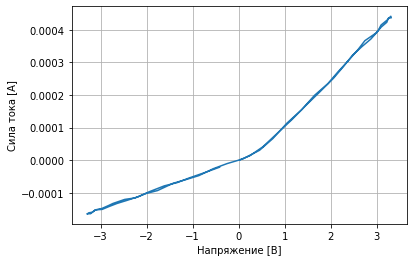

Wall time: 559 ms


In [5]:
%%time
circuit = Circuit('RD')
circuit.include(spice_library['1N4148'])
circuit.R(1,'input',1,10@u_kOhm)
circuit.X('D1', '1N4148', 1, circuit.gnd)
circuit.R(2,'input',circuit.gnd,20@u_kOhm)

analysis = CreateCVC(circuit)
        
plt.grid()
plt.plot(analysis.input_dummy, analysis.VCurrent)
plt.xlabel('Напряжение [В]')
plt.ylabel('Сила тока [А]')
plt.show()



### Пример ресэмплинга для сигналов с разным количеством точек

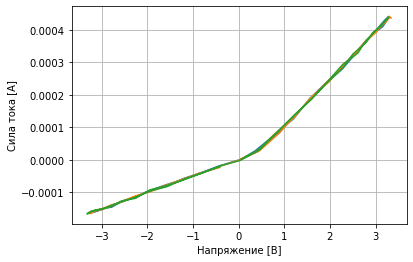

In [6]:

NewPoints = 50
for Points in [120,170,1000]:
    circuit = Circuit('RD')
    circuit.include(spice_library['1N4148'])
    circuit.R(1,'input',1,10@u_kOhm)
    circuit.X('D1', '1N4148', 1, circuit.gnd)
    circuit.R(2,'input',circuit.gnd,20@u_kOhm)
    
    CurveTracer_Settings(lendata=Points)
    analysis = CreateCVC(circuit)

    plt.grid()
    input_dummy = resample(analysis.input_dummy, NewPoints)
    VCurrent = resample(analysis.VCurrent, NewPoints)
    plt.plot(input_dummy, VCurrent)
    
plt.xlabel('Напряжение [В]')
plt.ylabel('Сила тока [А]')
plt.show()

### как построена база?
каждой схеме соответствует папка, в которой хранятся файлы массивов симуляции c номиналами схемы и параметрами прибора,и circuit файл - информация о самой схеме

In [7]:
%%time
def save_cir_analysis(fileName,circuit_params,curve_params,analysis):
    """ save circuit nominals,curve tracer parameters, voltage and current arrays to file"""
    with open(fileName, 'wb') as f:
        np.save(f,circuit_params)
        np.save(f,curve_params)
        np.save(f,analysis.VCurrent)
        np.save(f,analysis.input_dummy)
    
def make_sure_path(path_title):
    """ create path if path not exist, return full path """
    dirName = os.path.join(FILEBASE_ROOT,path_title)
    if not os.path.exists(dirName):
        os.makedirs(dirName)
    return dirName

def save_circuit(dirName,circuit):
    """ save sample circuit on disk """
    fileName = os.path.join(dirName,circuit.title+'.cir')
    with open(fileName,'w') as f:
        f.write(str(circuit))
        

Wall time: 0 ns


In [8]:
def load_circuit_dataset(path_dataset,ct_settings=None,shuffle=True,max_files=None,resample_len=1):
    """ load dataset from circuit folder.
    return X,y """
    fileList = [f for f in os.listdir(path_dataset) if f.endswith('.npy')]
    
    if shuffle: 
        random.shuffle(fileList)
        
    if max_files is not None:
        max_files = min(max_files,len(fileList))
        fileList=fileList[0:max_files]
    
    X_data,y_data=[],[]
    
    for fileName in tqdm(fileList): # process files
        with open(os.path.join(path_dataset,fileName), 'rb') as f:
            circuit_params = np.load(f)
            curve_params = np.load(f)
            VCurrent = np.load(f)
            input_dummy = np.load(f)  
            
            # использование старой базы сигналов для обучения модели.
            # старую базу можно использовать, но модели нужно перестраивать заново
            if resample_len is not None: # ресэмплинг сигнала из базы
                if resample_len==1: # берем текущие настройки прибора по умолчанию
                    resample_len = ct_default_settings.lendata
                    
                if not len(VCurrent)==resample_len:
                    VCurrent = resample(VCurrent,resample_len)
                    input_dummy = resample(input_dummy,resample_len)
                    
            if ct_settings is not None: 
                ct = CurveTracer_Settings().from_numpy(curve_params)
                F_ok = math.abs(ct_settings.F-ct.F) < 0.1
                V_ok = math.abs(ct_settings.V-ct.V) < 0.05
                if (F_ok and V_ok)==False:
                    continue
                    
                len_ok = ct_settings.lendata == ct.lendata
                cyc_ok = ct_settings.cycle == ct.cycle
                if (len_ok and cyc_ok)==False:
                    continue
                    
                #Rcs_ok = math.abs(ct_settings.Rcs-ct.Rcs) < 1
                #SNR_ok = True #math.abs(ct_settings.SNR-ct.SNR) < 1
        
        # append data to arrays
        y_data.append(circuit_params)
        X_data.append([VCurrent,input_dummy])
        
    return np.array(X_data),np.array(y_data)

## препроцессор данных для моделей -
### делает преобразование фурье, прореживание и прочие манипуляции со входными сигналами

#### Мотивация к добавлению в признаковое пространство конкретных алгебраических величин (закон Ома):

Ток $I=V/R$

Сопротивление $R=V/I$

Проводимость $\sigma=1/R=I/V$

Напряжение на конденсаторе $V=C*Q$

Заряд конденсатора $Q=\int Idt \sim \sum {I}$ 

Емкость конденсатора $C=V/Q$ или $C \sim V/\sum {I}$

Диф. сопротивление $R_d= \frac {\Delta {V}} {\Delta{I}}$

Диф. Проводимость $\sigma_d=1/R_d=\Delta {I}/\Delta {V}$

Напряжение на индуктивности $ V = -L \frac {\Delta{I}} {\Delta{t}} \sim L\Delta{I}$

Величина индуктивности $L \sim \frac {V} {\Delta{I}}$

##### Итого - параметры R, C, L линейно связаны с сигналами V, I, их производными (изменениями от точке к точке) и интегралами (суммами)


#### Мотивация к использованию логарифмов:

$\log {(AB)} = \log {A}+\log {B} $

$\log {\frac {A} {B}} = \log {A}-\log{B}$

##### Итого - можно взять логарифмы от исходных сигналов, их производных и интегралов, и линейная модель их свяжет с логарифмами искомых параметров R, C, L. 

In [9]:
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from scipy.fft import rfft

def my_xgb_transform_function(X):
    """ feature engineering on raw analysis signal data.
    Transformations - fft image, input signal resampling etc.""" 
    Xa = []
    for x in X:
        I_signal = x[:len(x)//2] # current      
        V_signal = x[len(x)//2:] # input voltage - not use
        I_fft = rfft(I_signal)
        I_fft = I_fft[:20] # use only first 20 points on freq domain
        I_abs = np.abs(I_fft)
        I_angle = np.angle(I_fft)
        I_real = np.real(I_fft)
        I_imag = np.imag(I_fft)
        
        V_fft = rfft(V_signal)
        V_fft = V_fft[:20] # use only first 20 points on freq domain
        V_abs = np.abs(V_fft)
        V_angle = np.angle(V_fft)
        V_real = np.real(V_fft)
        V_imag = np.imag(V_fft)

        x1 = np.hstack((x,I_abs,I_angle,I_real,I_imag,V_abs,V_angle,V_real,V_imag))
        Xa.append(x1)
        
    return np.array(Xa)

MyXGBTransformer = FunctionTransformer(my_xgb_transform_function)


## базовый класс схем

In [10]:
import pickle
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor,RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.pipeline import make_pipeline

class BaseCircuitModel():
    """ base class for circuit models. Provide training, data preprocessing,
    prediction for nominal values """
    def __init__(self,title='baseAbstract',modelDir=None,modelName=None):
        self.title = title
        self.modelDir = os.path.join(FILEBASE_ROOT,self.title) if (modelDir is None) else modelDir  
        make_sure_path(self.modelDir)
        self.modelName = title+'.pickle' if (modelName is None) else modelName   
        self.modelFileName = os.path.join(self.modelDir,self.modelName)
        self.optimize_save_flag = False
        
        try:
            self.load_model()
        except OSError as e:
            print(e)
            print('rebuild model ...')
            self.rebuild_model()
        
    
    def load_model(self):
        with open(self.modelFileName, "rb") as f:
                self.model = pickle.load(f)
                self.rank = self.model.rank # number of circuit variative nominals
    
    def save_model(self):
        with open(self.modelFileName, "wb") as f:
                self.model.rank = self.rank
                pickle.dump(self.model, f)
        
    def write_dataset(self,Xvals,Vtest=(1.,2.5,3.3,5.0)):
        """ circuit batch simulation over params Xvals"""
        for v in Vtest:
            for xval in tqdm(Xvals): # walk over nominals in circuit and create I/V curves
                #print(xval)
                cir_params = np.array(xval)
                circuit = self.build_circuit(cir_params)
                analysis = CreateCVC(circuit,ct=CurveTracer_Settings(V=v))
                fileName = os.path.join(self.modelDir,uuid.uuid4().hex+'.npy')
                save_cir_analysis(fileName,cir_params,ct_default_settings.to_numpy(),analysis)

    def load_dataset(self):
        """ load dataset from disk. Can be overwritten for feature construction"""
        X_data,y_data = load_circuit_dataset(self.modelDir)
        ADim = X_data.shape[0]
        X_data = X_data.reshape(ADim,-1)
        if self.rank==1: # fit shape 1d regression or Nd regression 
            y_data = y_data.reshape(-1)
        else:
            y_data = y_data.reshape(ADim,-1)
            
        return X_data,y_data
        
    def build_model(self,estimator=None, save_model=True, test_model=True ): 
        print('dataset for model '+self.title+' is loading, please wait..')
        
        if estimator is None:
            baseEstimator = GradientBoostingRegressor()
            if self.rank>1:
                self.model = make_pipeline(MyXGBTransformer,RegressorChain(baseEstimator))
            else:
                self.model = make_pipeline(MyXGBTransformer,baseEstimator)
        else:
            self.model = estimator
        
        X_data,y_data = self.load_dataset()  
        print('model '+self.title+' is training, please wait..')
        self.model.fit(X_data,y_data)
        self.model.rank = self.rank
        
        if save_model:
            self.save_model()
            self.load_model()
        
        if test_model:
            print('test_model() routine for '+self.title+' model:')
            self.test_model()
    
    def test_model(self):
        print('!!WARNING : test_model() routine for '+self.title+' model not implemented')
            
    def predict_from_model(self,analysis0):
        """ predict X values for circuit, best fitted to analysis0 """
        X = np.array([analysis0.VCurrent,analysis0.input_dummy]).reshape(-1)
        a = self.model.predict([X])[0]
        return a
        
    def misfit(self,analysis0, Xvals=None):
        """ calculate mse for current from circuit from Xval simulation and from analysis"""
        if Xvals is None:
            Xvals = self.predict_from_model(analysis0)
            
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit)
        
        return mean_squared_error(analysis1.VCurrent,analysis0.VCurrent)
    
    def _optimize_func(self,Xvals):      
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit)
        
        if self.optimize_save_flag:
            fileName = os.path.join(self.modelDir,'o_'+uuid.uuid4().hex+'.npy')
            save_cir_analysis(fileName,Xvals,ct_default_settings.to_numpy(),analysis1)

        return mean_squared_error(analysis1.VCurrent,self._analysis0.VCurrent)

    def optimize_from_X(self,analysis0,Xvalues = None):
        if Xvalues is None:
            Xvalues = self.predict_from_model(analysis0).reshape(-1)
        self._analysis0 = analysis0 #
        
        optimize_result = minimize(self._optimize_func,Xvalues)
        
        return (optimize_result.x, optimize_result)
        
    


### Реализация конкретных схем из резисторов, емкостей, индуктивностей и диодов 
## rank 1, rank 2

In [11]:
######################################################################

class R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('R')
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        r1 = np.abs(r1)
        circuit = Circuit('R')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        
        Xr = np.random.uniform(0.1,100,size=50)
        self.write_dataset(Xr)
        Xr = np.random.uniform(0.0,5,size=50)
        self.write_dataset(Xr)
        
        self.build_model()
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
            
Circuit_Set.add(R_circuit)
    
######################################################################

class C_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('C')
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            c1 = Xvals
        elif isinstance(Xvals, list):
            c1 = Xvals[0]
        else: # it is numpy array
            c1 = Xvals.item()
        c1 = np.abs(c1)
        circuit = Circuit('C')
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        X = np.random.uniform(1e-3,100.,size=50)
        self.write_dataset(X)
        self.build_model()
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for c in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(c))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-c)/c)
            print(str(c),str(x),str(acc),sep='\t')
    
Circuit_Set.add(C_circuit)
    
######################################################################

class L_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('L')
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            l1 = Xvals
        elif isinstance(Xvals, list):
            l1 = Xvals[0]
        else: # it is numpy array
            l1 = Xvals.item()
        l1 = np.abs(l1)
        circuit = Circuit('L')
        circuit.L(1,'input',circuit.gnd,l1@u_uH)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        Xr = np.random.uniform(1e-3,500,size=1000)
        self.write_dataset(Xr)
        
        self.build_model()
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for l in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 175., 398., 700.]):
            analysis0 = CreateCVC(self.build_circuit(l))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-l)/l)
            print(str(l),str(x),str(acc),sep='\t')
        
Circuit_Set.add(L_circuit)
######################################################################

class DR_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR')
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        r1 = np.abs(r1)
        circuit = Circuit('DR')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', circuit.gnd)
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        Xr = np.random.uniform(0.1,100,size=50)
        self.write_dataset(Xr)
        Xr = np.random.uniform(0.0,5,size=50)
        self.write_dataset(Xr)
        
        self.build_model()
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    
Circuit_Set.add(DR_circuit)
######################################################################

class D_R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('D_R')       
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        r1 = np.abs(r1)
        circuit = Circuit('D_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        Xr = np.random.uniform(0.1,100,size=50)
        self.write_dataset(Xr)
        Xr = np.random.uniform(0.0,5,size=50)
        self.write_dataset(Xr)
        self.build_model()
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    
Circuit_Set.add(D_R_circuit)
###################################################################

class RC_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('RC')
        
    def build_circuit(self,Xvals):
        Xvals = np.abs(Xvals)
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('RC')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
        
    def rebuild_model(self):
        self.rank = 2
        X = np.random.uniform(low=[0.1,1e-3],high=[100.,100.],size=(1000,2))
        self.write_dataset(X)
        self.build_model()
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]))
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
Circuit_Set.add(RC_circuit)
###################################################################

class R_C_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('R_C')
            
    def build_circuit(self,Xvals):
        Xvals = np.abs(Xvals)
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('R_C')
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.C(1,2, circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_model(self):
        self.rank = 2
        X = np.random.uniform(low=[0.1,1e-3],high=[100.,100.],size=(1000,2))
        self.write_dataset(X)
        self.build_model()
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]))
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
Circuit_Set.add(R_C_circuit)
###################################################################

class DR_R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR_R')
        
    def build_circuit(self,Xvals): 
        Xvals = np.abs(Xvals)
        r1,r2 = Xvals[0],Xvals[1]
        
        circuit = Circuit('DR_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.R(2,2,circuit.gnd,r2@u_kOhm)
        
        return circuit

    
    def rebuild_model(self):
        self.rank = 2
        X = np.random.uniform(low=[0.1,0.1],high=[100.,100.],size=(1000,2))
        self.write_dataset(X)
        self.build_model()
        
    def test_model(self):
        print('real r1','real r2','r1?','r2?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        for r1,r2 in zip(R1,R2):
            analysis0 = CreateCVC(self.build_circuit([r1,r2]))
            r1x,r2x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r1x),str(r2x),sep='\t')
    
Circuit_Set.add(DR_R_circuit)
    
###################################################################

class DR_DR_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR_DR')
        
    def build_circuit(self,Xvals): 
        Xvals = np.abs(Xvals)
        r1,r2 = Xvals[0],Xvals[1]
        
        circuit = Circuit('DR_DR')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        circuit.X('D2', '1N4148', 3, 'input')
        circuit.R(2,3,circuit.gnd,r2@u_kOhm)
        
        return circuit

    
    def rebuild_model(self):
        self.rank = 2
        X = np.random.uniform(low=[0.1,0.1],high=[100.,100.],size=(1000,2))
        self.write_dataset(X)
        self.build_model()
        
    def test_model(self):
        print('r1','r2','r1?','r2?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        for r1,r2 in zip(R1,R2):
            analysis0 = CreateCVC(self.build_circuit([r1,r2]))
            r1x,r2x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r1x),str(r2x),sep='\t')
    
Circuit_Set.add(DR_DR_circuit)

In [12]:
#EP = RC_circuit()

### Реализация конкретных схем из резисторов, емкостей, индуктивностей и диодов 
## rank 3

In [13]:
###################################################################

class DR_DR_R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR_DR_R')
        
    def build_circuit(self,Xvals): 
        Xvals = np.abs(Xvals)
        r1,r2,r3 = Xvals[0],Xvals[1],Xvals[2]
        
        circuit = Circuit('DR_DR_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        circuit.X('D2', '1N4148', 3, 'input')
        circuit.R(2,3,circuit.gnd,r2@u_kOhm)
        circuit.R(3,'input',circuit.gnd,r3@u_kOhm)
        
        return circuit

    
    def rebuild_model(self):
        self.rank = 3
        X = np.random.uniform(low=[0.1,0.1,0.1],high=[100.,100.,100.],size=(1000,3))
        self.write_dataset(X)
        self.build_model()
        
    def test_model(self):
        print('r1','r2','r3','r1?','r2?','r3?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        R3 = [1., 0.1, 10., 30., 5.]
        for r1,r2,r3 in zip(R1,R2,R3):
            analysis0 = CreateCVC(self.build_circuit([r1,r2,r3]))
            r1x,r2x,r3x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r3),str(r1x),str(r2x),str(r3x),sep='\t')
    
Circuit_Set.add(DR_DR_R_circuit)

### тестирование разных схем

In [14]:
EP = C_circuit()
EP.test_model()



[Errno 2] No such file or directory: 'E:\\EyePoint\\C\\C.pickle'
rebuild model ...


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 158.72it/s]


dataset for model C is loading, please wait..


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 408.97it/s]


model C is training, please wait..
test_model() routine for C model:
actual c 	 predicted c 	 acc dc/c 
0.1	4.356276171261507	42.562761712615064
1.0	8.398475425968648	7.398475425968648
1.1	6.374361213138874	4.7948738301262495
3.0	6.855797276204411	1.2852657587348038
10.0	9.502294532940518	0.04977054670594825
15.0	25.84595039888423	0.7230633599256154
22.0	19.962205374134918	0.09262702844841283
30.0	26.080829793904748	0.13063900686984173
50.0	48.61656118289239	0.027668776342152198
70.0	69.1926607017177	0.011533418546890013
75.0	74.65219882895067	0.00463734894732435
98.0	95.281652297889	0.027738241858275548
100.0	93.83519133984245	0.061648086601575475
actual c 	 predicted c 	 acc dc/c 
0.1	6.247180371043975	61.47180371043975
1.0	12.36986223170968	11.36986223170968
1.1	7.409446199860542	5.735860181691401
3.0	14.046207610087587	3.682069203362529
10.0	11.977004883839681	0.19770048838396814
15.0	19.04345029131142	0.26956335275409465
22.0	20.407454673932754	0.07238842391214752
30.0	23.39720947

### Класс для предсказания схемы по ВАХ

In [15]:
class CircuitPredictor():
    """ class for circuit prediction from i,v curves using list of various circuit models"""
    def __init__(self):
        # append all availible circuit models to this list 
        self.circuitModels = []
        for cir in Circuit_Set:
            self.circuitModels.append(cir())
    
    
    def predict_from_model(self,analysis0):
        """"""
        m_List = []
        for m in self.circuitModels:
            Xvars = m.predict_from_model(analysis0)
            err = m.misfit(analysis0,Xvars)
            m_List.append((Xvars,m,err))
            
        m_List = sorted(m_List, key = lambda k:k[2])
        best = m_List[0] # best suited model
        return best
    
    def test_me(self):
        """"""
        self.test_rankN(1)
        self.test_rankN(2)
        self.test_rankN(3)
        
    def test_rankN(self,N,runsCount = 100,plot_Ok=10,plot_Fail=30):
        print('RANK'+str(N)+' CIRCUIT TESTING ..')
        CIR_N = []
        for cir in Circuit_Set:
            cN = cir()
            if cN.rank==N:
                CIR_N.append(cN)
                
        count_ok = 0
        count_fail = 0
        
        for _ in range(runsCount): 
            objCir = random.choice(CIR_N)
            
            x = 100*np.random.random(N)
            
            analysis0 = CreateCVC(objCir.build_circuit(x))
            Xvars, objX,_ = self.predict_from_model(analysis0)
            if isinstance(objX,type(objCir)):
                print('success: '+str(x)+' -> '+str(Xvars)+' circuit '+objX.title)
                count_ok += 1
                if plot_Ok>0:
                    plot_Ok -=1
                    analysis1 = CreateCVC(objX.build_circuit(Xvars))
                    print('SUCCESS:')
                    plot_analysis_IV(analysis0)
                    plot_analysis_IV(analysis1)
                    plt.show()
            else:
                print('!!fail:  '+str(x)+' -> '+str(Xvars)+' '+objCir.title+' detected like '+objX.title)
                count_fail += 1
                if plot_Fail>0:
                    plot_Fail -=1
                    analysis1 = CreateCVC(objX.build_circuit(Xvars))
                    print('FAIL:')
                    plot_analysis_IV(analysis0)
                    plot_analysis_IV(analysis1)
                    plt.show()
                
        print('\nSUCCESS: '+str(count_ok)+', FAIL: '+str(count_fail)+' of '+str(count_ok+count_fail)+' tests')
   

### тестирование класса предсказания схем

[Errno 2] No such file or directory: 'E:\\EyePoint\\R\\R.pickle'
rebuild model ...


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 154.79it/s]


dataset for model R is loading, please wait..


100%|███████████████████████████████████████| 400/400 [00:00<00:00, 596.98it/s]


model R is training, please wait..
test_model() routine for R model:
actual r 	 predicted r 	 acc dr/r 
0.1	0.6150628046193998	5.150628046193997
1.0	1.4170273814512715	0.4170273814512715
1.1	1.4682760902134957	0.33479644564863237
3.0	3.2711629238563162	0.09038764128543875
10.0	10.158185517292432	0.015818551729243246
15.0	12.204887214297015	0.18634085238019898
22.0	21.18336311202557	0.03711985854429223
30.0	25.931519801020364	0.13561600663265452
50.0	49.14084762674908	0.017183047465018433
70.0	76.88979478221101	0.09842563974587161
75.0	76.44253966148932	0.019233862153190937
98.0	87.38154404901515	0.10835159133658012
100.0	88.84987182921766	0.11150128170782338
[Errno 2] No such file or directory: 'E:\\EyePoint\\DR_DR\\DR_DR.pickle'
rebuild model ...


100%|██████████████████████████████████████| 1000/1000 [00:14<00:00, 70.85it/s]


dataset for model DR_DR is loading, please wait..


100%|█████████████████████████████████████| 4000/4000 [00:07<00:00, 539.49it/s]


model DR_DR is training, please wait..
test_model() routine for DR_DR model:
r1	r2	r1?	r2?
0.1	1.0	-1.3515215713007052	4.945932596424972
2.0	0.1	11.861993642507757	3.7050780094628846
5.0	10.0	4.233843166827644	12.666408200243469
10.0	30.0	10.49349085362748	29.61740281573869
70.0	5.0	66.3149933979659	4.261812801033593
[Errno 2] No such file or directory: 'E:\\EyePoint\\DR_DR_R\\DR_DR_R.pickle'
rebuild model ...


100%|██████████████████████████████████████| 1000/1000 [00:15<00:00, 62.76it/s]


dataset for model DR_DR_R is loading, please wait..


100%|█████████████████████████████████████| 4000/4000 [00:08<00:00, 474.37it/s]


model DR_DR_R is training, please wait..
test_model() routine for DR_DR_R model:
r1	r2	r3	r1?	r2?	r3?
0.1	1.0	1.0	-1.2317529967949947	43.45265081553683	11.32511994916825
2.0	0.1	0.1	33.47908581386831	9.972089053752635	9.301505969574151
5.0	10.0	10.0	1.8255275518278196	38.14542454430466	11.288600020806086
10.0	30.0	30.0	7.195863605759707	43.408930459214226	30.481315785059163
70.0	5.0	5.0	43.42091816057069	7.764475167448349	17.164006574467013
[Errno 2] No such file or directory: 'E:\\EyePoint\\DR_R\\DR_R.pickle'
rebuild model ...


100%|██████████████████████████████████████| 1000/1000 [00:16<00:00, 58.87it/s]


dataset for model DR_R is loading, please wait..


100%|█████████████████████████████████████| 4000/4000 [00:08<00:00, 465.31it/s]


model DR_R is training, please wait..
test_model() routine for DR_R model:
real r1	real r2	r1?	r2?
0.1	1.0	-7.580652043611529	18.247517348025553
2.0	0.1	10.30946499953733	-0.5936555536506174
5.0	10.0	3.3389691433064685	9.205828011916113
10.0	30.0	5.754816793293762	29.036379050355524
70.0	5.0	73.26229260244895	6.429023740964922
[Errno 2] No such file or directory: 'E:\\EyePoint\\R_C\\R_C.pickle'
rebuild model ...


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 76.82it/s]


dataset for model R_C is loading, please wait..


100%|█████████████████████████████████████| 4000/4000 [00:07<00:00, 520.87it/s]


model R_C is training, please wait..
test_model() routine for R_C model:
real r	real c	r?	c?	real rc	rc?
0.1	1.0	6.799737147395104	33.55384354376415	0.1	228.15731638241647
2.0	0.1	4.683918462378251	27.532148817561033	0.2	128.95834015551964
5.0	10.0	5.964080832413606	41.97024435080168	50.0	250.3139298643317
10.0	30.0	11.597852722298535	50.56269270180527	300.0	586.4186631983765
70.0	5.0	69.30834744517583	46.91660338108888	350.0	3251.7122480840194
[Errno 2] No such file or directory: 'E:\\EyePoint\\RC\\RC.pickle'
rebuild model ...


100%|██████████████████████████████████████| 1000/1000 [00:11<00:00, 88.82it/s]


dataset for model RC is loading, please wait..


100%|█████████████████████████████████████| 4000/4000 [00:08<00:00, 485.41it/s]


model RC is training, please wait..
test_model() routine for RC model:
real r	real c	r?	c?	real rc	rc?
0.1	1.0	50.92670028189332	0.5198683081633879	0.1	26.475177515891808
2.0	0.1	29.272752347506604	-0.061215260427793426	0.2	-1.791939158390918
5.0	10.0	53.15268332289961	10.5614639957797	50.0	561.3701511938843
10.0	30.0	57.6436115125438	31.275842678321272	300.0	1802.8525250765888
70.0	5.0	47.84363045675613	4.691599426097558	350.0	224.4631491933407
[Errno 2] No such file or directory: 'E:\\EyePoint\\D_R\\D_R.pickle'
rebuild model ...


100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 31.85it/s]


dataset for model D_R is loading, please wait..


100%|███████████████████████████████████████| 400/400 [00:01<00:00, 323.08it/s]


model D_R is training, please wait..
test_model() routine for D_R model:
actual r 	 predicted r 	 acc dr/r 
0.1	0.3881598045819017	2.881598045819017
1.0	1.4642363949788744	0.46423639497887437
1.1	1.299143834046009	0.18103984913273544
3.0	3.2213968148625733	0.07379893828752444
10.0	10.62196031305116	0.06219603130511597
15.0	14.629424891140374	0.02470500725730839
22.0	19.81575703086832	0.09928377132416731
30.0	30.60912683057813	0.020304227685937686
50.0	49.94556103394698	0.0010887793210604003
70.0	68.55408707151136	0.020655898978409123
75.0	77.0622364207545	0.027496485610060024
98.0	93.33995595210123	0.04755146987651801
100.0	93.4832530632843	0.06516746936715706
[Errno 2] No such file or directory: 'E:\\EyePoint\\DR\\DR.pickle'
rebuild model ...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 81.56it/s]


dataset for model DR is loading, please wait..


100%|███████████████████████████████████████| 400/400 [00:00<00:00, 497.48it/s]


model DR is training, please wait..
test_model() routine for DR model:
actual r 	 predicted r 	 acc dr/r 
0.1	4.82996332185333	47.2996332185333
1.0	37.295569820933615	36.295569820933615
1.1	43.654173211474685	38.68561201043153
3.0	43.780715653355145	13.593571884451714
10.0	29.050826697727047	1.9050826697727046
15.0	32.15165197529073	1.143443465019382
22.0	10.838457842663411	0.5073428253334813
30.0	16.434993553515223	0.4521668815494925
50.0	28.17232391831613	0.4365535216336774
70.0	23.067396974805693	0.6704657575027758
75.0	15.644307229814544	0.7914092369358061
98.0	13.661075249982686	0.8606012729593603
100.0	14.844253106140835	0.8515574689385916
[Errno 2] No such file or directory: 'E:\\EyePoint\\L\\L.pickle'
rebuild model ...


100%|██████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


dataset for model L is loading, please wait..


100%|█████████████████████████████████████| 4000/4000 [00:12<00:00, 317.04it/s]


model L is training, please wait..
test_model() routine for L model:
actual c 	 predicted c 	 acc dc/c 
0.1	219.55521218974627	2194.5521218974627
1.0	9.619927451307486	8.619927451307486
1.1	12.693013714185481	10.539103376532255
3.0	5.0895420472294015	0.6965140157431339
10.0	12.782142127309077	0.27821421273090774
15.0	15.627634130089593	0.04184227533930619
22.0	21.81222553623943	0.008535202898207668
30.0	33.11534186910452	0.10384472897015064
50.0	45.97218887498406	0.08055622250031874
70.0	68.30884570362255	0.024159347091106398
175.0	166.30495838457244	0.04968595208815746
398.0	405.20201114571086	0.018095505391233304
700.0	527.3383774216685	0.24665946082618787
RANK1 CIRCUIT TESTING ..
success: [44.25821678] -> 25.695324013803145 circuit DR
SUCCESS:


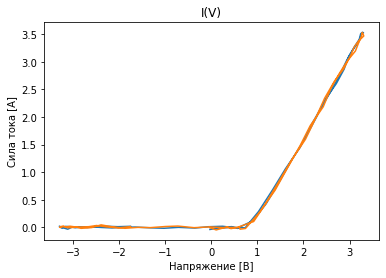

success: [68.92226327] -> 22.19470929206335 circuit DR
SUCCESS:


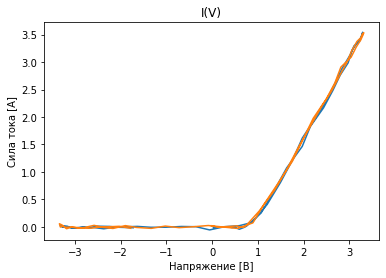

success: [95.54243047] -> 5.351046708942021 circuit DR
SUCCESS:


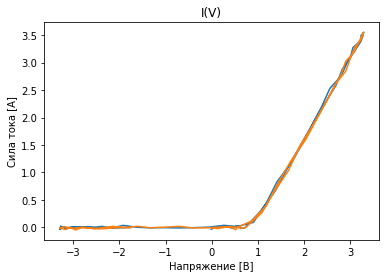

!!fail:  [83.29800344] -> [47.71800015 84.64764494] C detected like RC
FAIL:


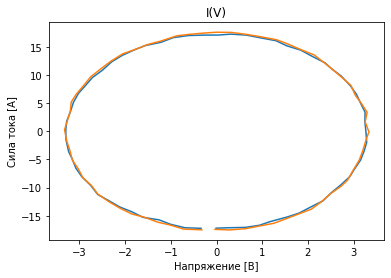

success: [83.7876412] -> 16.227258888188697 circuit DR
SUCCESS:


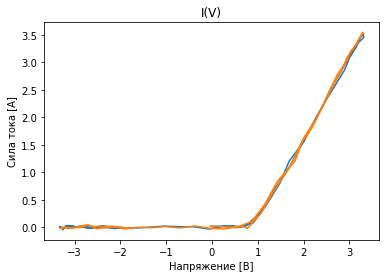

!!fail:  [10.19244529] -> [52.23122771 12.29649955] C detected like RC
FAIL:


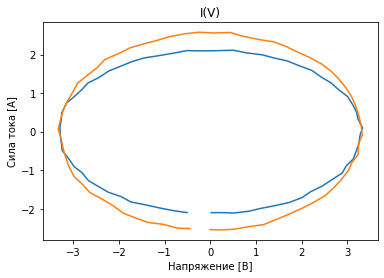

success: [85.29557816] -> 92.1874803211829 circuit D_R
SUCCESS:


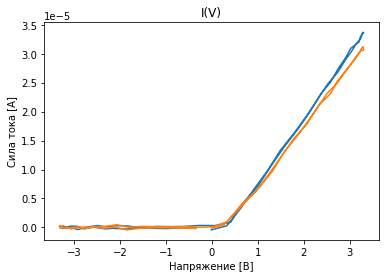

success: [82.26811559] -> 87.87339949892127 circuit D_R
SUCCESS:


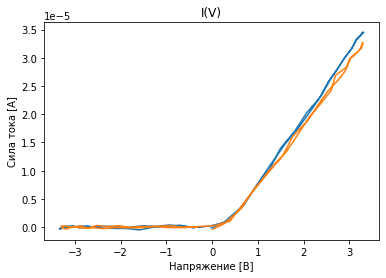

success: [7.81922323] -> 40.42046902870639 circuit DR
SUCCESS:


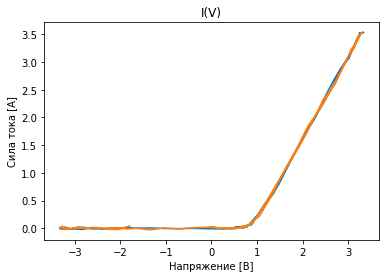

!!fail:  [96.47480272] -> [95.08194835 48.54765175] R detected like R_C
FAIL:


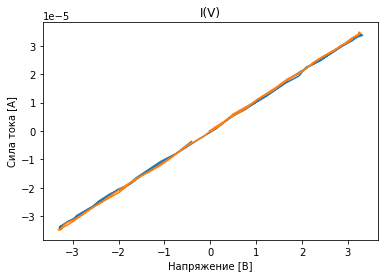

!!fail:  [95.69196354] -> [47.85806493 94.15223289] C detected like RC
FAIL:


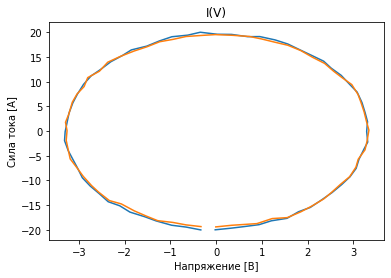

success: [79.59884893] -> 82.90348024199716 circuit D_R
SUCCESS:


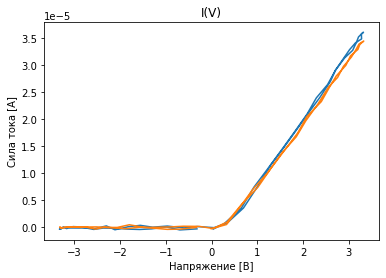

!!fail:  [20.93362016] -> [21.03536713 50.83900166] R detected like R_C
FAIL:


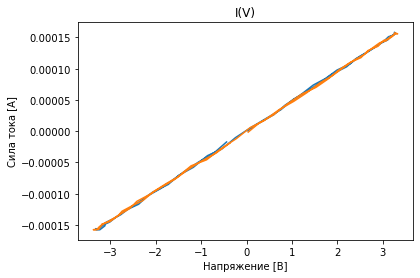

success: [34.81503121] -> 36.80788091671505 circuit C
SUCCESS:


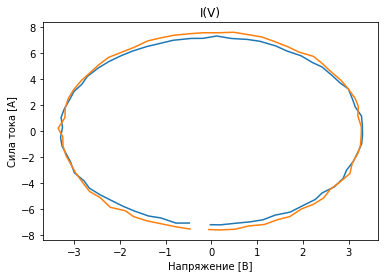

!!fail:  [25.71462867] -> [52.7144354  24.49911496] C detected like RC
FAIL:


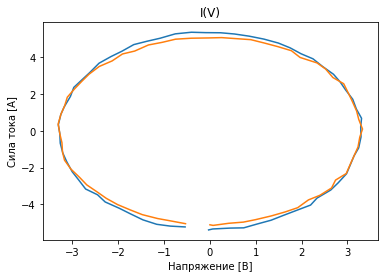

success: [91.18425939] -> 91.73413156733166 circuit D_R
SUCCESS:


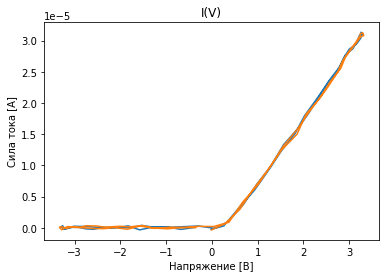

success: [82.00357759] -> 34.27843701718329 circuit DR
!!fail:  [25.08582413] -> [24.28569724 42.36044444] R detected like R_C
FAIL:


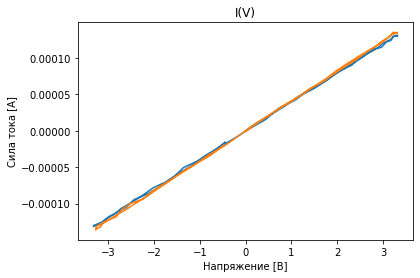

success: [97.7211867] -> 35.195434296798496 circuit DR
!!fail:  [23.21257918] -> [93.02773893 92.42489767 30.28332432] R detected like DR_DR_R
FAIL:


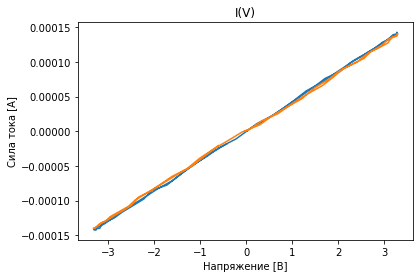

success: [18.6023263] -> 17.691069457182113 circuit D_R
success: [9.03619796] -> 9.096520106949669 circuit R
success: [48.33476792] -> 46.92736531314548 circuit D_R
success: [4.77643517] -> 6.3822980638454965 circuit DR
!!fail:  [76.82668559] -> [78.19985469 55.01414257] R detected like R_C
FAIL:


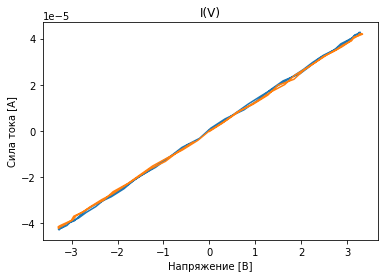

success: [6.46830499] -> 11.117741370084438 circuit DR
success: [61.38509113] -> 61.849092335153564 circuit L
success: [5.39678038] -> 34.184247645413215 circuit DR
success: [96.45629555] -> 93.74511470540793 circuit D_R
success: [42.82577131] -> 44.40241014661163 circuit D_R
!!fail:  [35.59491081] -> [54.53507823 36.76658327] C detected like RC
FAIL:


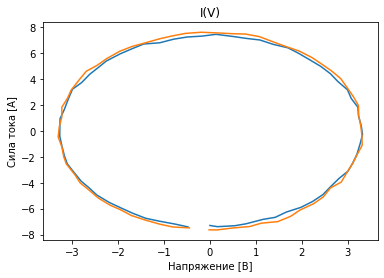

success: [60.61304932] -> 61.61811748361332 circuit R
success: [13.16401851] -> 14.830193228905806 circuit L
!!fail:  [97.35666944] -> [58.48424098 96.69649813] C detected like RC
FAIL:


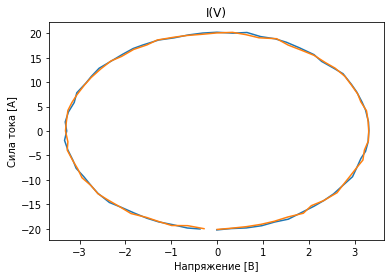

success: [17.99232182] -> 17.849872932616123 circuit R
!!fail:  [27.00072614] -> [85.88223317 88.09457457 38.70707504] R detected like DR_DR_R
FAIL:


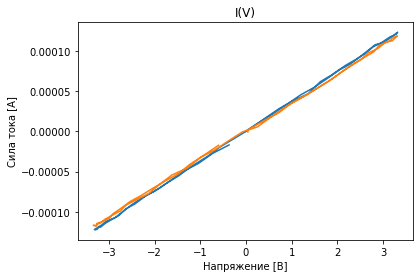

success: [65.4303407] -> 12.424058071284735 circuit DR
success: [10.49866188] -> 10.577909978686188 circuit D_R
!!fail:  [20.7267789] -> [54.70013337 20.42167519] C detected like RC
FAIL:


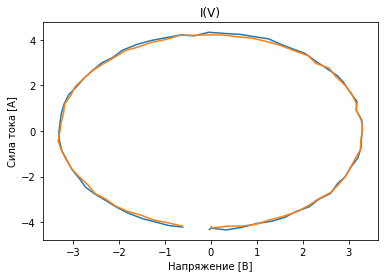

!!fail:  [15.00166434] -> [50.85973363 13.77552711] C detected like RC
FAIL:


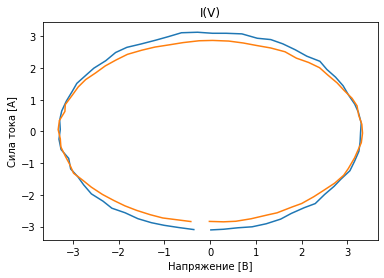

success: [26.7963909] -> 29.379403929925033 circuit L
success: [31.68042679] -> 33.712341833417035 circuit L
success: [63.26030628] -> 62.35091683407122 circuit L
success: [53.12383591] -> 49.67517979808549 circuit D_R
success: [73.19911673] -> 66.84176811951099 circuit L
success: [94.02458833] -> 28.163385242881844 circuit DR
success: [60.83367493] -> 63.52066169262246 circuit C
success: [25.86001494] -> 24.448305891363376 circuit R
success: [52.99952731] -> 51.28892517523871 circuit L
success: [32.57473971] -> 31.42185616247623 circuit R
success: [48.3123555] -> 48.382199294829256 circuit C
success: [86.35476908] -> 89.29417974394616 circuit D_R
success: [15.85399215] -> 28.55551459475313 circuit DR
success: [75.54584332] -> 76.55238047407282 circuit C
success: [2.87284004] -> 6.757046211839663 circuit L
success: [47.2998937] -> 45.23412895664235 circuit D_R
success: [25.15681943] -> 23.572070558861476 circuit R
success: [7.28241872] -> 12.06335493993125 circuit L
success: [62.736757

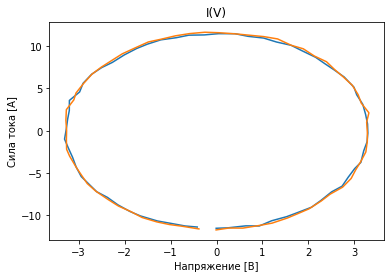

success: [50.69016228] -> 51.25020005864409 circuit D_R
!!fail:  [60.38969002] -> [54.67483553 66.03406859] C detected like RC
FAIL:


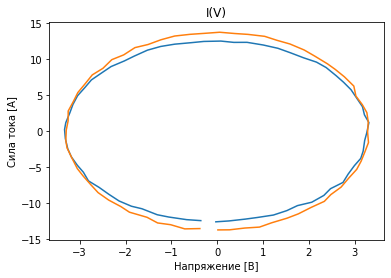

!!fail:  [86.48071542] -> [86.36471766 47.59908431] R detected like R_C
FAIL:


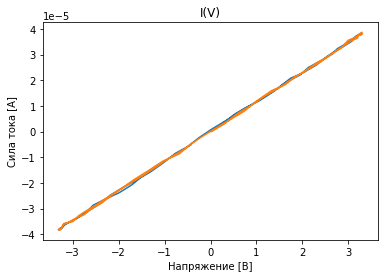

!!fail:  [74.76609076] -> [ 2.85905489 71.96091335] R detected like DR_R
FAIL:


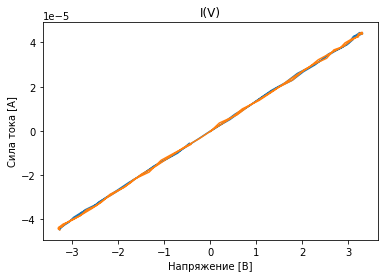

!!fail:  [21.94209932] -> [23.88689651 51.79218203] R detected like R_C
FAIL:


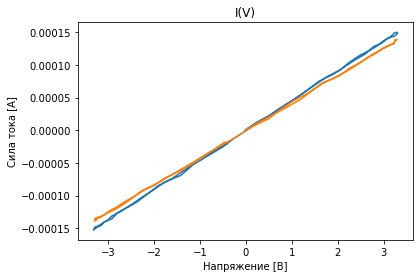

!!fail:  [71.97093696] -> [ 3.46559826 69.49803996] R detected like DR_R
FAIL:


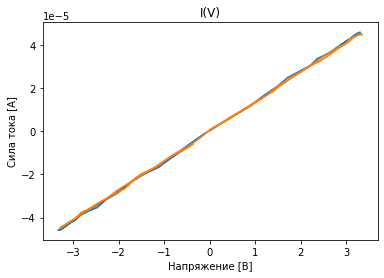

!!fail:  [72.95976675] -> [52.39320948 71.1439503 ] C detected like RC
FAIL:


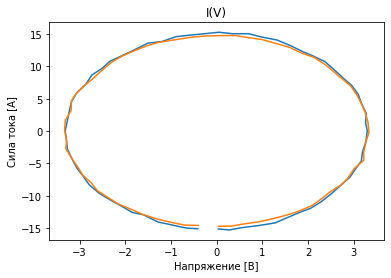

success: [1.96764796] -> 9.232878803674266 circuit DR
success: [80.59447627] -> 81.81208139204256 circuit D_R
!!fail:  [99.51134717] -> [96.71222273 43.80310217] R detected like R_C
FAIL:


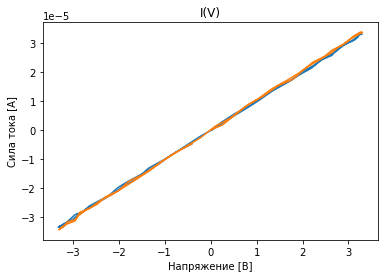

!!fail:  [69.07531532] -> [ 3.28282347 67.01881447] R detected like DR_R
FAIL:


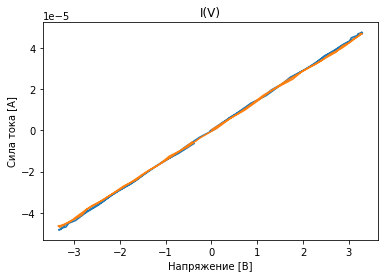

!!fail:  [56.75219277] -> [ 4.08488885 46.27672064] R detected like DR_R
FAIL:


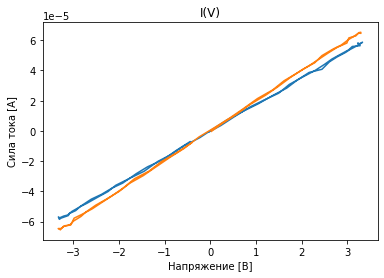

success: [13.07762213] -> 10.680687331692381 circuit R
success: [3.69839189] -> 7.239417783984198 circuit L
success: [87.47962876] -> 15.223954561919363 circuit DR
success: [59.99894096] -> 21.949647421272847 circuit DR
success: [9.42987178] -> 13.270704091417157 circuit L
success: [85.67152559] -> 24.026003840897623 circuit DR
!!fail:  [55.27367022] -> [ 2.93505897 56.07294472] R detected like DR_R
FAIL:


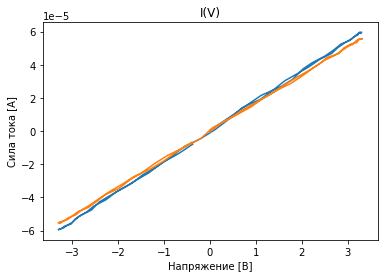

success: [93.96323779] -> 97.48257585577757 circuit L
!!fail:  [77.89682261] -> [79.68174325 47.88001964] R detected like R_C
FAIL:


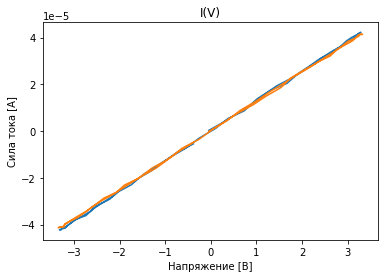

success: [6.80247463] -> 6.323977735290753 circuit R
success: [16.07033662] -> 6.89101279831188 circuit DR
!!fail:  [23.17606934] -> [22.8098486  46.94933406] R detected like R_C
FAIL:


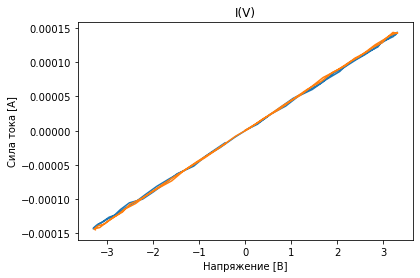

success: [22.44226584] -> 24.862365212584216 circuit L
success: [62.15326813] -> 63.07154967399299 circuit D_R
!!fail:  [64.49763991] -> [ 1.92544414 65.25973488] R detected like DR_R
FAIL:


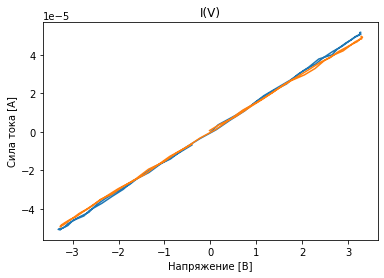

success: [96.66183448] -> 9.679960916561726 circuit DR
success: [78.34112618] -> 27.68746613203594 circuit DR
success: [88.73546669] -> 16.380142070488134 circuit DR
success: [93.13902606] -> 92.8389893428825 circuit D_R
success: [18.03728026] -> 17.30830484968663 circuit L
!!fail:  [86.79869583] -> [86.36471766 46.34800021] R detected like R_C
FAIL:


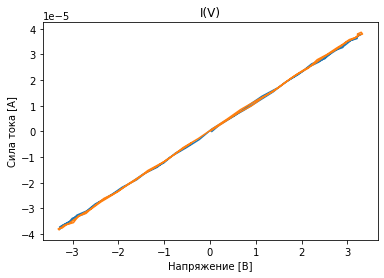

success: [58.91433832] -> 58.62999192526321 circuit C
!!fail:  [99.41524125] -> [95.34668856 43.70317428] R detected like R_C
FAIL:


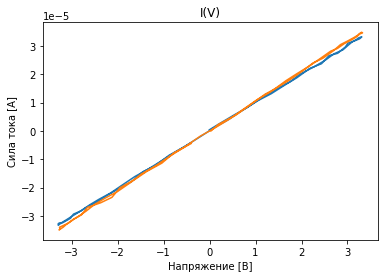

success: [41.29648367] -> 42.861888072771265 circuit D_R
!!fail:  [93.23330777] -> [95.68500562 41.94094164] R detected like R_C
success: [77.07997751] -> 19.277853829945222 circuit DR
success: [50.02419069] -> 52.35549213259373 circuit L

SUCCESS: 69, FAIL: 31 of 100 tests
RANK2 CIRCUIT TESTING ..
success: [29.93598388 93.68580333] -> [49.81378781 94.12508048] circuit RC
SUCCESS:


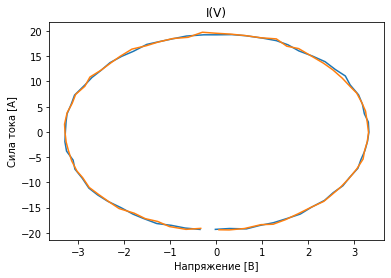

success: [20.13752148 97.57904525] -> [48.18918395 95.8189547 ] circuit RC
SUCCESS:


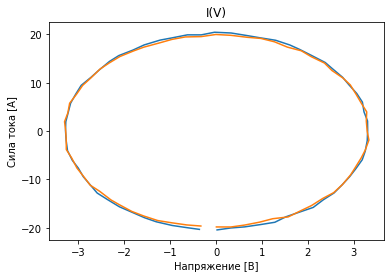

success: [24.20248782 50.06018118] -> [23.97173562 54.58355668] circuit DR_DR
SUCCESS:


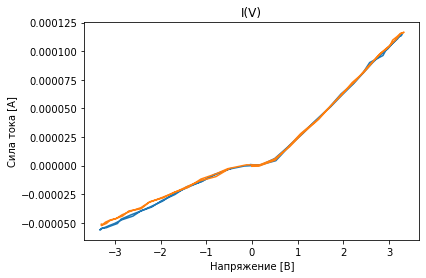

success: [85.98988442 97.38139529] -> [82.43368277 92.29784516] circuit DR_R
SUCCESS:


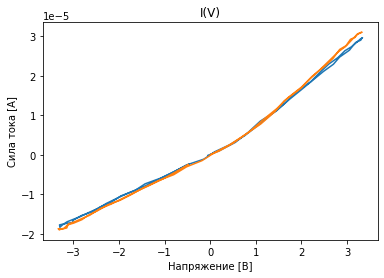

success: [96.31180987 35.63827433] -> [54.13834397 35.86455037] circuit RC
SUCCESS:


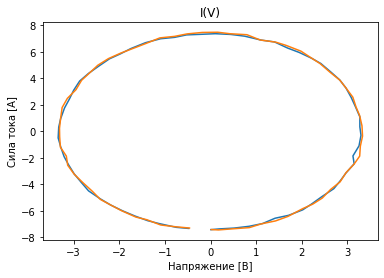

!!fail:  [41.82932697 34.24873886] -> [44.70343667 44.98667822] DR_DR detected like R_C
FAIL:


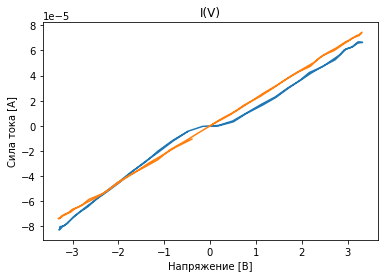

success: [68.87158863 13.43432216] -> [43.97724294 12.44987646] circuit RC
SUCCESS:


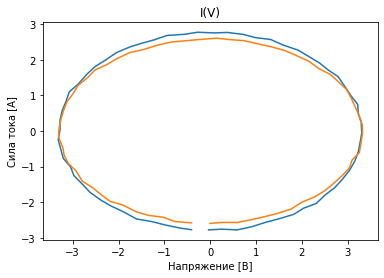

!!fail:  [72.08384994 84.95226144] -> 84.7390662543707 RC detected like C
FAIL:


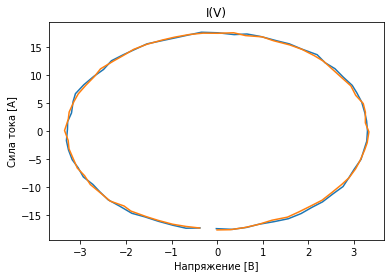

success: [85.9627103  61.26920994] -> [83.1081243  63.54175588] circuit DR_R
SUCCESS:


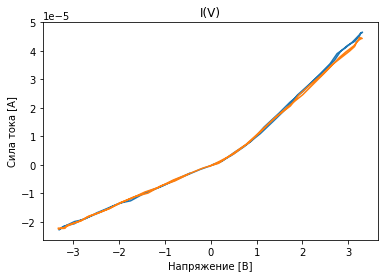

success: [84.06272468  7.36816599] -> [77.57298423  6.63888298] circuit DR_DR
SUCCESS:


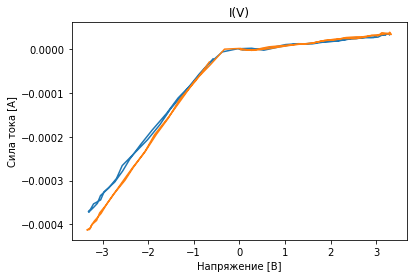

success: [76.12252406 91.50405092] -> [76.44749158 48.726067  ] circuit R_C
SUCCESS:


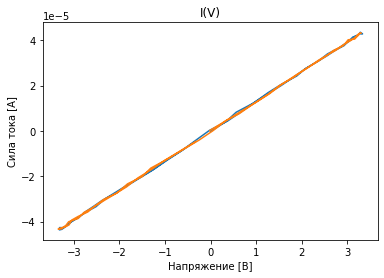

success: [38.83434932 59.79682908] -> [41.67749495 60.71161431] circuit DR_R
SUCCESS:


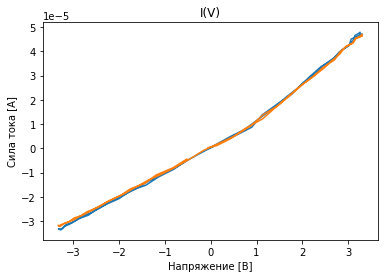

success: [95.89025938 56.56560769] -> [51.99410248 56.47387002] circuit RC
success: [20.71295689 56.17000402] -> [20.42934426 47.70159437] circuit R_C
success: [84.70126006 13.57693893] -> [52.30129442 12.35224567] circuit RC
!!fail:  [ 2.10679962 70.80016411] -> 73.189385420795 DR_R detected like R
FAIL:


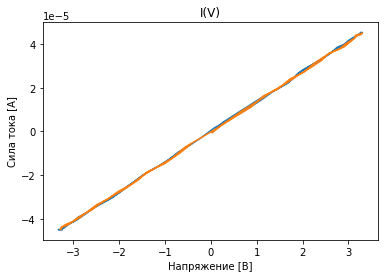

!!fail:  [ 0.60361413 37.33048839] -> 1.2679137041902588 R_C detected like R
FAIL:


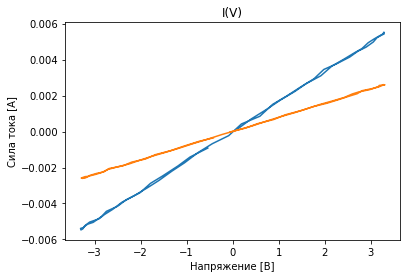

success: [40.16293356 82.10984725] -> [50.63136081 80.41382434] circuit RC
success: [87.45327034 34.79694505] -> [52.92999615 35.84228173] circuit RC
success: [66.51720293 78.68750627] -> [71.75237025 73.51242518] circuit DR_R
success: [65.65950188 17.04469661] -> [67.45411797 17.77576222] circuit DR_R
success: [80.25680457 84.28514999] -> [74.25601636 86.81780118] circuit DR_R
success: [22.65848629 88.79241688] -> [52.37359003 84.37524495] circuit RC
success: [67.40142119 86.24051022] -> [68.97370573 53.04178997] circuit R_C
success: [ 9.51333236 26.5900238 ] -> [53.44474275 24.04132906] circuit RC
!!fail:  [ 6.87090741 20.65004901] -> [59.56099358 87.52937264 38.96989267] DR_R detected like DR_DR_R
FAIL:


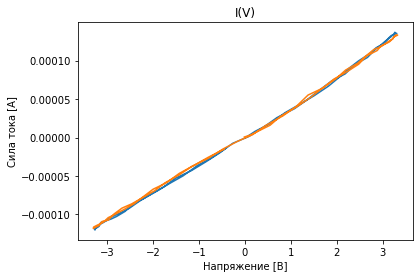

!!fail:  [19.01243445 33.82411877] -> [61.81377476 95.62661441 78.26250885] DR_R detected like DR_DR_R
FAIL:


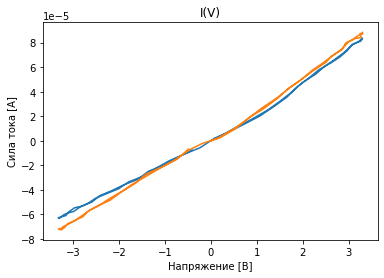

!!fail:  [16.72725103  9.06376776] -> 6.944497084022766 RC detected like C
FAIL:


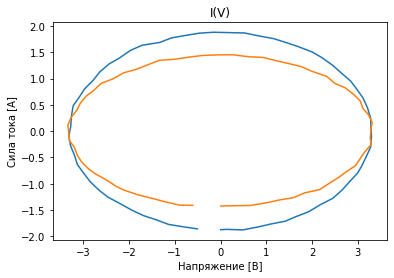

success: [42.85488703 47.83639156] -> [55.46048009 45.90040354] circuit DR_R
success: [22.28154861 11.35735159] -> [22.98711291  9.87201456] circuit DR_DR
success: [ 2.44709353 90.59427448] -> [50.04654127 90.34839361] circuit RC
success: [46.77404521 58.5155762 ] -> [48.00618355 62.19626764] circuit DR_DR
success: [47.90223292 93.41378693] -> [44.34261956 89.47840472] circuit DR_R
success: [19.42381926 42.50455797] -> [18.47338225 45.19446689] circuit DR_DR
success: [22.77079549 16.54244281] -> [22.11584511 50.08558094] circuit R_C
success: [ 7.23715199 68.1113608 ] -> [ 8.17235347 46.61893956] circuit R_C
success: [15.38765335 92.01426135] -> [49.76796958 94.92451338] circuit RC
success: [83.03173666 25.88462781] -> [59.16108034 24.40037989] circuit RC
success: [15.98210219 25.79599808] -> [17.27022016 50.65090702] circuit R_C
success: [ 8.00395172 44.41857679] -> [ 8.48838891 50.70841921] circuit R_C
success: [63.87883419 98.55219715] -> [67.50718959 94.04298907] circuit DR_R
!!fail

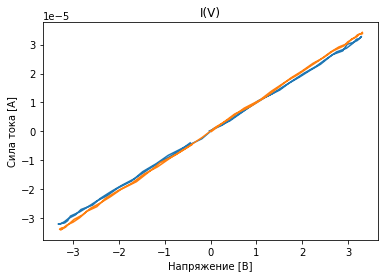

success: [32.77646167 69.59997229] -> [49.52440887 67.68796007] circuit RC
!!fail:  [12.891081   18.84215285] -> [85.94065482 94.06912287 14.00990746] R_C detected like DR_DR_R
FAIL:


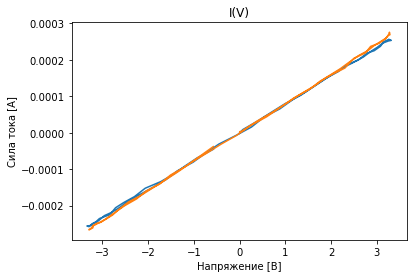

success: [13.48353562 59.25910775] -> [50.76442485 58.56671973] circuit RC
success: [89.37629085 80.02021185] -> [53.07057945 80.365271  ] circuit RC
success: [93.74248559 61.16286182] -> [87.68690406 57.72034448] circuit DR_DR
!!fail:  [ 7.13589372 79.33067328] -> [87.81543076 47.58408342] DR_R detected like R_C
FAIL:


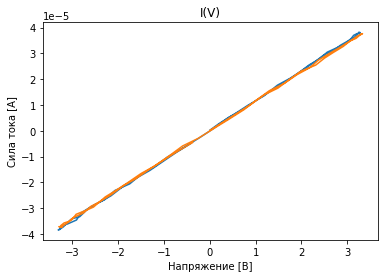

!!fail:  [27.59535258 39.31237644] -> 28.855466840301016 R_C detected like R
FAIL:


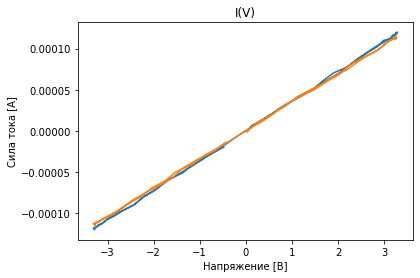

success: [18.25362637 95.76778536] -> [52.50743091 95.05566281] circuit RC
success: [44.29463473  6.23890241] -> [48.60932846  6.85892514] circuit DR_DR
success: [29.71459458 50.93046186] -> [29.29317125 58.29917172] circuit DR_DR
success: [49.46524761 16.18646469] -> [54.61088638 15.58253993] circuit DR_DR
success: [52.68287178  0.28499961] -> [42.86542963 -0.06599338] circuit RC
success: [34.13702724 57.92963858] -> [34.93976804 53.48449237] circuit R_C
success: [43.63796425 35.08647194] -> [44.74148914 37.08612856] circuit DR_R
success: [71.68453872 74.80252159] -> [43.36411069 77.11848059] circuit RC
success: [27.40085502 14.13631213] -> [27.82814528 51.65590476] circuit R_C
success: [87.17162072 15.65376047] -> [73.37057897 16.68585975] circuit DR_R
!!fail:  [1.65462037 4.61799046] -> [ 2.08815598 39.44436752 48.62418964] DR_DR detected like DR_DR_R
FAIL:


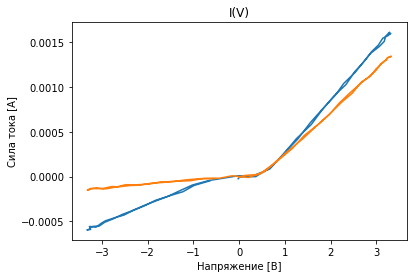

!!fail:  [21.45881683 62.04852622] -> 61.70364309062281 RC detected like C
FAIL:


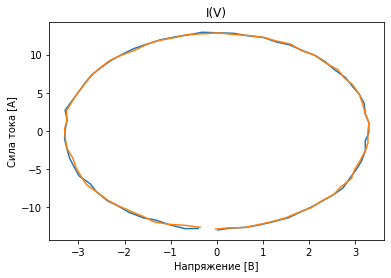

success: [53.18572304 93.17918007] -> [50.01268538 92.49938118] circuit DR_R
success: [68.58125484 92.50096766] -> [64.27425766 87.75649834] circuit DR_DR
!!fail:  [ 0.36268081 56.44330549] -> 59.32615098390141 RC detected like C
FAIL:


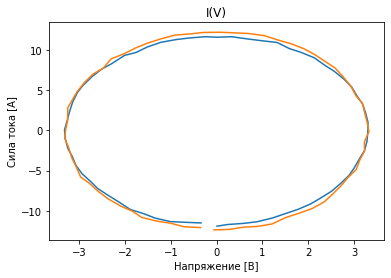

success: [91.20563573 21.06760729] -> [86.84218292 53.62135531] circuit R_C
success: [51.45392224 95.19840411] -> [50.6093177  52.35046157] circuit R_C
success: [65.27669613 39.08240442] -> [65.1457368  41.75121486] circuit DR_R
success: [30.55549091  9.28838138] -> [34.81765496  9.3843408 ] circuit DR_R
success: [98.88584095 42.97967871] -> [90.53411094 42.76518835] circuit DR_R
success: [25.88744451 76.43557705] -> [51.80119274 77.57023196] circuit RC
success: [22.43659649 71.2279087 ] -> [26.3062986  70.39282518] circuit DR_DR
!!fail:  [31.05376379 59.17643111] -> 61.47699713214949 RC detected like C
FAIL:


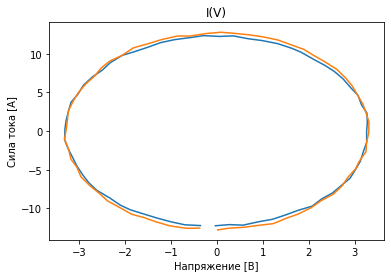

success: [99.50875611 40.69084908] -> [96.63494226 46.15345995] circuit R_C
success: [70.22849551 94.33758362] -> [43.02125131 93.54949875] circuit RC
success: [17.10145824 51.79139753] -> [16.95142951 49.19587062] circuit R_C
!!fail:  [ 0.32105311 80.82486225] -> 0.9495489204777224 DR_DR detected like D_R
FAIL:


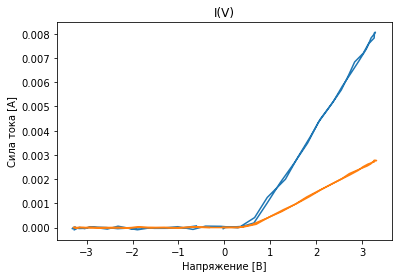

success: [48.96019923 75.96520005] -> [49.77612252 49.61581806] circuit R_C
!!fail:  [ 3.54819177 47.51916957] -> 47.643976228121446 RC detected like C
FAIL:


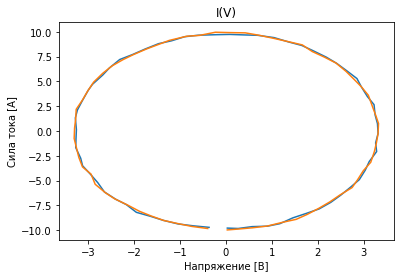

success: [74.2240113  56.42580913] -> [76.1244384  57.80983075] circuit DR_DR
success: [81.9941766  98.93272612] -> [81.79703937 51.8586602 ] circuit R_C
success: [95.92555877 32.078047  ] -> [54.05605726 33.35025267] circuit RC
!!fail:  [32.45447754  6.35141375] -> 8.167276440752799 RC detected like C
FAIL:


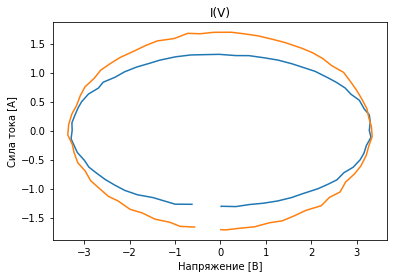

success: [56.04196372 77.64388004] -> [52.98900949 81.54669049] circuit DR_R
success: [37.39500702 46.17060343] -> [36.60818445 35.93259111] circuit R_C
success: [52.93289497 73.23974485] -> [52.36650793 78.96819512] circuit DR_R
success: [ 5.37096467 95.94246066] -> [ 5.94711149 86.27959607] circuit DR_DR
!!fail:  [73.15202033  8.74274016] -> 6.095607886129318 RC detected like C
FAIL:


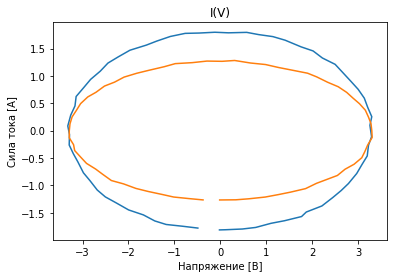

!!fail:  [52.49815529 54.05286698] -> [62.98827712 50.28856122] DR_DR detected like R_C
FAIL:


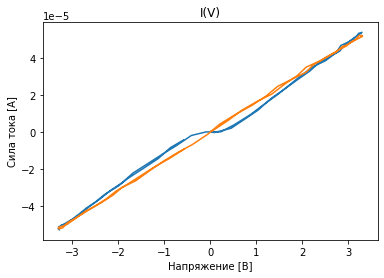

success: [84.23205852 56.94748943] -> [74.5846392  62.51369506] circuit DR_R
success: [40.99797086  6.22825253] -> [50.67164581  6.51048197] circuit DR_R
success: [64.64850271 51.9117176 ] -> [64.92466698 50.53616106] circuit R_C
!!fail:  [46.87952785 76.07094824] -> 47.95424603467164 R_C detected like R
FAIL:


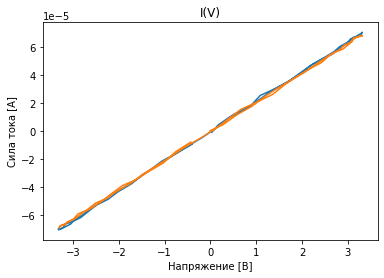

success: [19.62984806 75.48032801] -> [22.49125281 73.57243674] circuit DR_DR
success: [47.31597656 64.45866721] -> [47.43627578 50.88134315] circuit R_C
success: [38.05647003 61.96678427] -> [35.21306169 60.37912184] circuit DR_R
!!fail:  [99.82861325 15.63037836] -> [12.21312637 84.91497175] R_C detected like DR_R
FAIL:


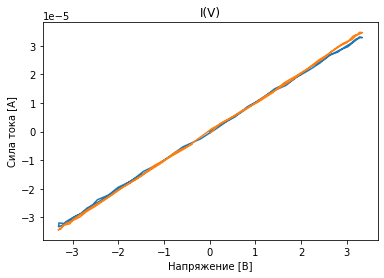

success: [19.35211286 37.42030897] -> [55.25943898 36.69796644] circuit RC
success: [73.08316251 93.26089298] -> [73.44918908 42.27200741] circuit R_C
success: [53.63606318 50.93100841] -> [56.54296144 52.4833589 ] circuit R_C
success: [74.48179359 78.76355355] -> [44.43524907 81.72020462] circuit RC

SUCCESS: 78, FAIL: 22 of 100 tests
RANK3 CIRCUIT TESTING ..
success: [78.33364509 28.74520722 99.20646149] -> [86.58912074 33.45415685 82.07162783] circuit DR_DR_R
SUCCESS:


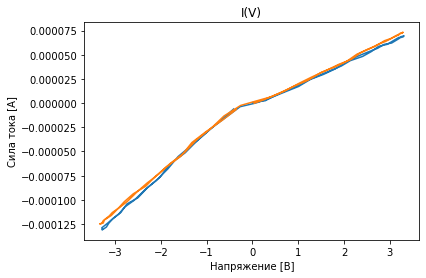

success: [69.07561381 41.21085794 80.40275738] -> [70.79357283 42.43048084 78.45305498] circuit DR_DR_R
SUCCESS:


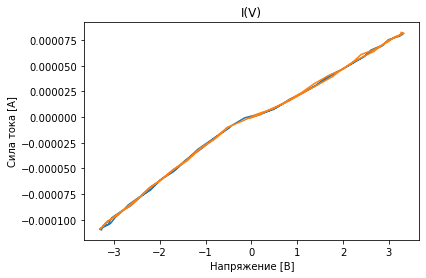

success: [48.03737568  6.28112749 50.94932375] -> [56.89513036  6.61997951 58.85551262] circuit DR_DR_R
SUCCESS:


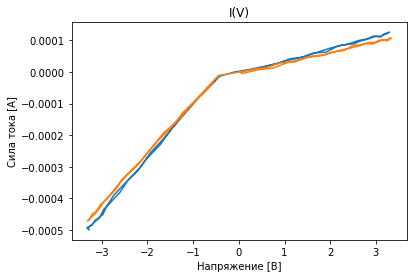

!!fail:  [71.74180283 45.93708014 36.17639459] -> [25.40967713 39.93165065] DR_DR_R detected like R_C
FAIL:


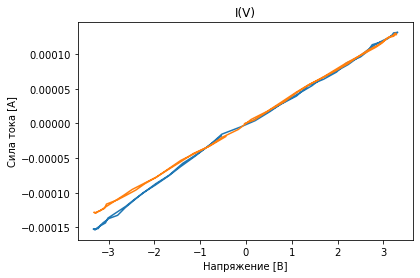

success: [84.50778403 35.29374238 84.25786381] -> [84.72261755 40.78530055 79.50967236] circuit DR_DR_R
SUCCESS:


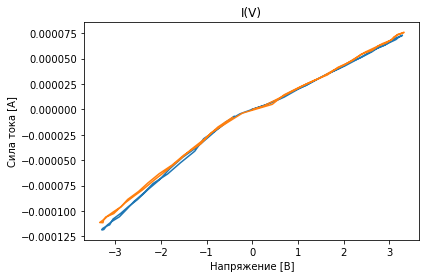

success: [11.93317254 87.80735352 55.18416058] -> [11.77514053 72.91632604 60.14959294] circuit DR_DR_R
SUCCESS:


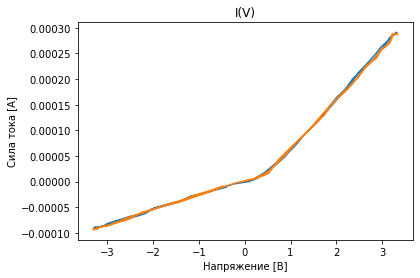

success: [82.41902794 39.38200147 61.74400546] -> [80.91996387 43.35310186 63.99472312] circuit DR_DR_R
SUCCESS:


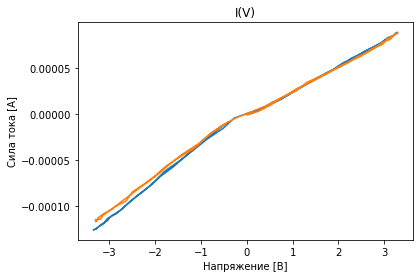

success: [25.68532099 92.23881527 44.64167534] -> [25.10328349 79.65077618 56.9606481 ] circuit DR_DR_R
SUCCESS:


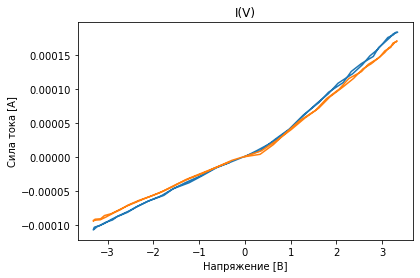

!!fail:  [91.75680799 43.07191164 15.54973468] -> 12.594528553408207 DR_DR_R detected like R
FAIL:


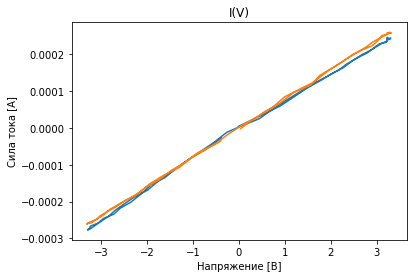

success: [11.78579782 97.14771177 29.37828496] -> [14.58087165 63.93926405 40.29148844] circuit DR_DR_R
SUCCESS:


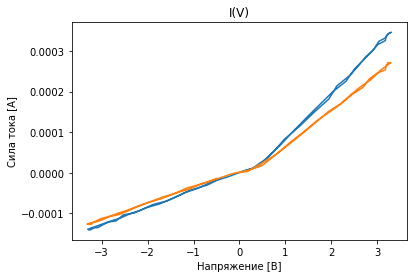

!!fail:  [ 0.54548395 31.56406565 40.56976506] -> 0.8739238827790593 DR_DR_R detected like D_R
FAIL:


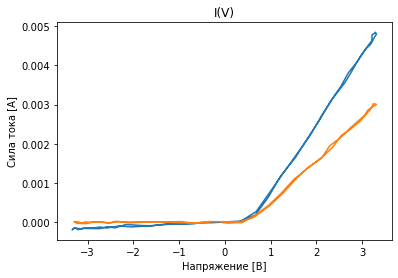

success: [71.11997171 22.9252464  84.79350274] -> [73.47321053 26.80699893 78.06910406] circuit DR_DR_R
SUCCESS:


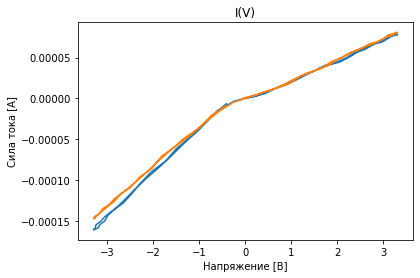

!!fail:  [30.04398186 71.97616302  1.38538944] -> 1.9958805796884016 DR_DR_R detected like R
FAIL:


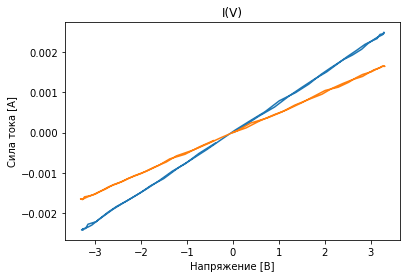

!!fail:  [36.0562128  75.82572048  6.40706289] -> 6.604184210537827 DR_DR_R detected like R
FAIL:


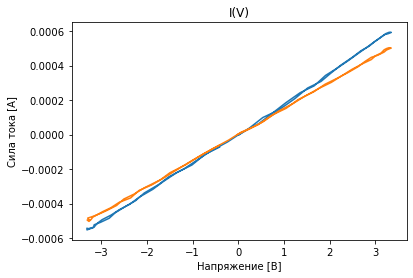

success: [16.39303988 55.45437284 31.51401554] -> [14.01697474 47.91532963 46.12281056] circuit DR_DR_R
SUCCESS:


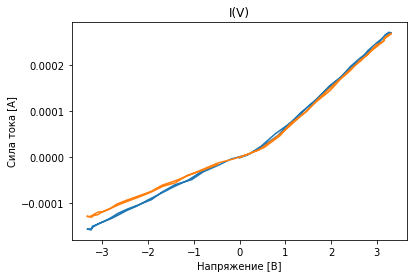

success: [93.76393278 14.2162228  51.55653806] -> [68.92047965 14.03439521 67.10108085] circuit DR_DR_R
!!fail:  [40.71008621 84.78578565 16.60593025] -> 11.268250918844492 DR_DR_R detected like R
FAIL:


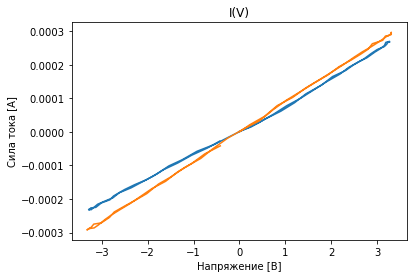

success: [62.12623566 31.73721157 67.96568368] -> [65.45831989 33.92945993 67.34425077] circuit DR_DR_R
success: [12.85383225 60.81605201 37.6674704 ] -> [13.35720767 53.0354953  53.5899758 ] circuit DR_DR_R
!!fail:  [22.74262303 83.74688882 13.71394032] -> 12.326842904011967 DR_DR_R detected like R
FAIL:


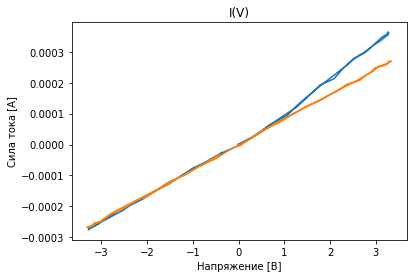

success: [16.29356884 44.82692393 21.92478301] -> [14.93915659 50.13323111 26.08234776] circuit DR_DR_R
!!fail:  [38.71114813 20.92269462  9.62099422] -> 8.184074913619234 DR_DR_R detected like R
FAIL:


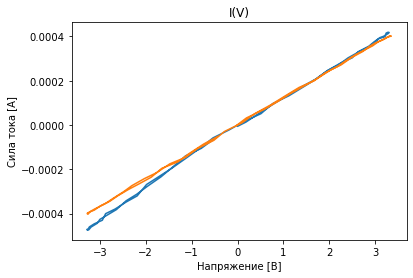

success: [86.42987443 62.4452323  76.05285767] -> [82.15570124 58.70830955 81.17932587] circuit DR_DR_R
!!fail:  [86.36224695 91.72871664 10.27640981] -> [ 9.32676388 46.85721701] DR_DR_R detected like R_C
FAIL:


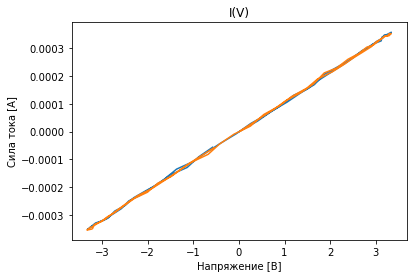

!!fail:  [68.87110351 70.03877939  0.38989609] -> 0.7468271612831133 DR_DR_R detected like R
FAIL:


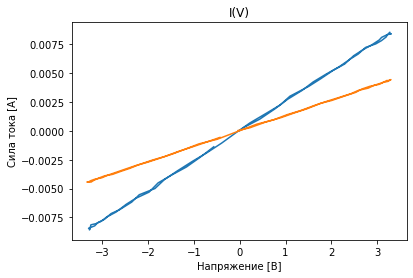

!!fail:  [59.88384794 33.47101567 33.06706725] -> [21.89424406 43.94500999] DR_DR_R detected like R_C
FAIL:


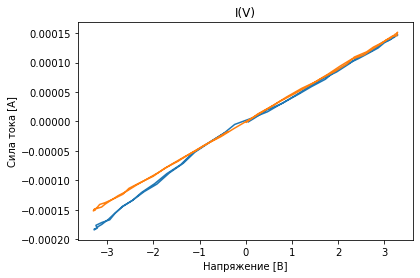

!!fail:  [59.68132213 61.21278408 11.51912636] -> [12.08598565 48.30893279] DR_DR_R detected like R_C
FAIL:


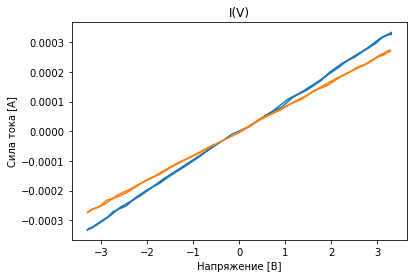

!!fail:  [39.00317148 27.06283825 64.11656508] -> [26.51014729 48.22871403] DR_DR_R detected like R_C
FAIL:


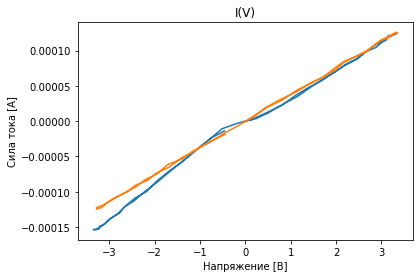

success: [74.29774757 68.90860002 62.12387308] -> [76.48899252 69.70671307 60.92680639] circuit DR_DR_R
success: [13.83397188 79.15020934 79.87569976] -> [14.42589563 74.3374279  78.17827152] circuit DR_DR_R
!!fail:  [54.21453268  3.5173816  20.95593264] -> [12.0454634   3.53120346] DR_DR_R detected like DR_DR
FAIL:


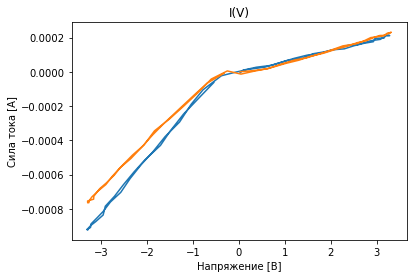

success: [47.03983842 89.28617877 16.83281655] -> [58.4040491  94.35047172 14.18802432] circuit DR_DR_R
success: [74.24234741 26.90816939 82.31647317] -> [77.05667786 26.34435922 80.01912041] circuit DR_DR_R
success: [36.88014233 50.13103244 61.04536151] -> [31.63780153 56.82317893 63.2436459 ] circuit DR_DR_R
!!fail:  [ 5.1093045  55.51342014 10.16656741] -> [5.26057714 8.41466003] DR_DR_R detected like DR_DR
FAIL:


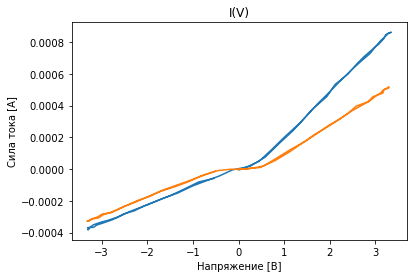

success: [36.11405294 10.54611186 48.24545874] -> [45.96335041  9.79449773 58.95359711] circuit DR_DR_R
success: [41.40309798 42.35529287 47.7394401 ] -> [44.53378713 44.65079934 48.3335801 ] circuit DR_DR_R
success: [49.91900194 61.17273972 72.58975685] -> [52.01311541 71.04364135 72.56608814] circuit DR_DR_R
success: [46.43991194 42.6390133  74.94442776] -> [46.40210192 41.40834353 66.74415697] circuit DR_DR_R
!!fail:  [37.12524233 63.19762492 34.73468204] -> [22.82866386 40.97315715] DR_DR_R detected like R_C
FAIL:


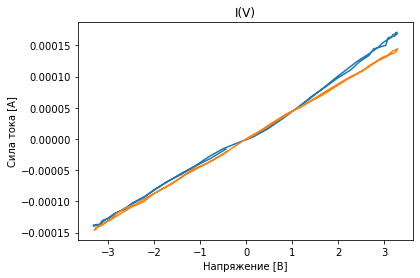

!!fail:  [61.59086398 82.60157019 34.59762041] -> [24.13521056 34.77729322] DR_DR_R detected like R_C
FAIL:


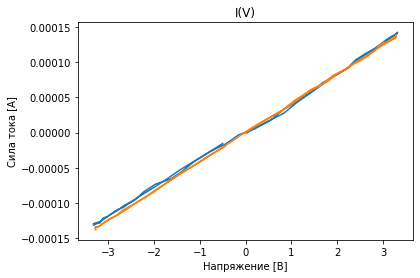

success: [63.64969768 97.67886668 84.83963801] -> [59.88476741 93.17035208 83.6901    ] circuit DR_DR_R
success: [20.90091747 54.02520953 52.02618507] -> [22.51717284 66.24209867 58.7645287 ] circuit DR_DR_R
success: [ 6.76772792 81.65910071 12.1172215 ] -> [ 5.2726306  46.19541462 16.09928966] circuit DR_DR_R
!!fail:  [16.1258335  42.07238947 10.5844652 ] -> 9.270608794739758 DR_DR_R detected like R
FAIL:


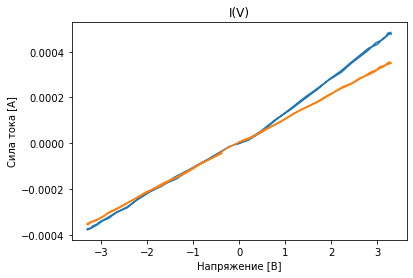

success: [52.18257449 89.64378374 36.26526675] -> [49.54331638 76.59637393 43.64628888] circuit DR_DR_R
!!fail:  [27.9530244  51.46539645 10.2551865 ] -> 10.687513458434331 DR_DR_R detected like R
FAIL:


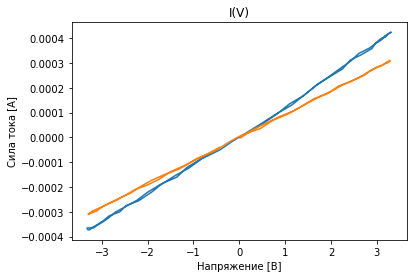

!!fail:  [88.47758588 51.25788439  5.65400864] -> 7.057335413107745 DR_DR_R detected like R
FAIL:


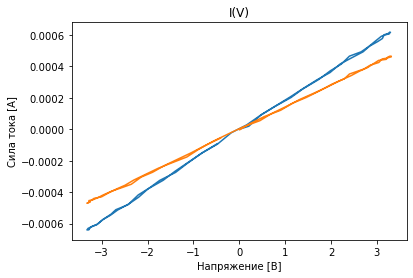

success: [41.02765964  7.18243185 79.94892776] -> [58.95085475  7.50562986 75.92698929] circuit DR_DR_R
!!fail:  [79.52082729 28.68913013 10.79805744] -> 9.23794911658098 DR_DR_R detected like R
FAIL:


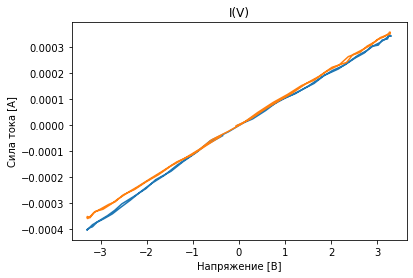

!!fail:  [63.42773828 38.30545092 45.17298941] -> [26.79517569 46.2001569 ] DR_DR_R detected like R_C
FAIL:


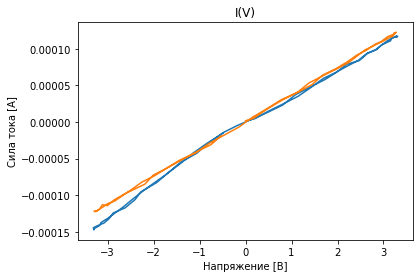

!!fail:  [86.63791553 51.82619765  6.99727595] -> 8.012554758271344 DR_DR_R detected like R
FAIL:


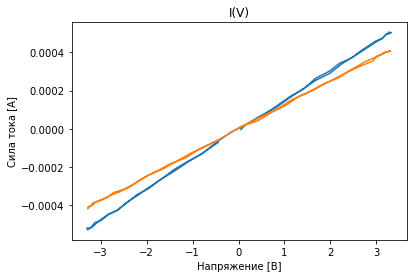

!!fail:  [57.13018536 59.43725373 10.59316378] -> 10.391833214096744 DR_DR_R detected like R
FAIL:


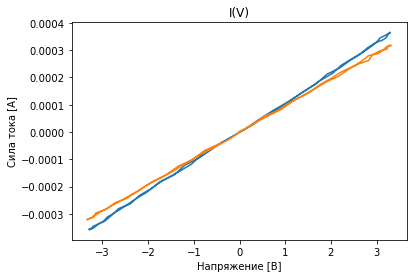

success: [77.44464435 92.76023948 78.71297738] -> [75.04322389 90.83279034 85.20466168] circuit DR_DR_R
success: [26.69231713 84.28607472 87.60875792] -> [30.46996043 82.81016008 80.34850733] circuit DR_DR_R
success: [60.83735836 68.27277587 52.91713962] -> [61.84088542 71.37097252 58.15893496] circuit DR_DR_R
success: [54.86406792 73.49355132 71.99402474] -> [56.928249   79.48903886 75.01878347] circuit DR_DR_R
!!fail:  [88.69311559 32.86802673 19.46087088] -> 15.350293770149865 DR_DR_R detected like R
FAIL:


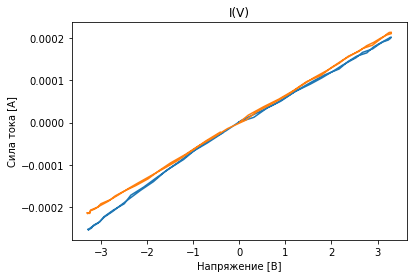

!!fail:  [ 0.78707781 28.62819296 23.32596306] -> 1.2810765518752376 DR_DR_R detected like D_R
FAIL:


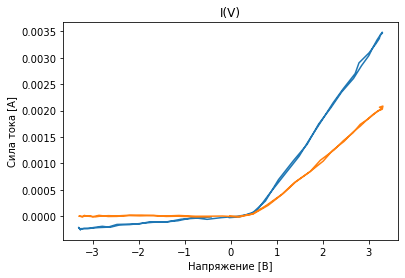

success: [36.01047565 57.12910387 66.05647118] -> [35.20931284 59.57136731 68.18595585] circuit DR_DR_R
!!fail:  [41.29947396 86.04670808 14.41173766] -> 12.460313994123002 DR_DR_R detected like R
FAIL:


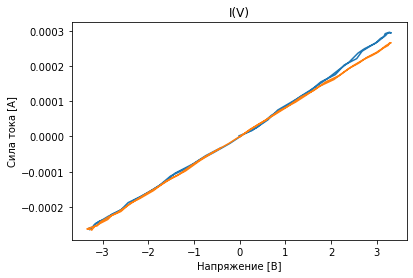

!!fail:  [28.68596163  9.08494866  2.36341903] -> [ 0.90700775 -1.69134192] DR_DR_R detected like DR_R
FAIL:


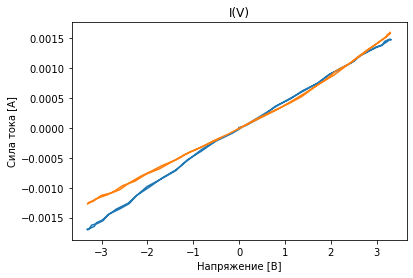

!!fail:  [34.10886523 31.30609895 76.19675281] -> [26.51538636 43.20149567] DR_DR_R detected like R_C
FAIL:


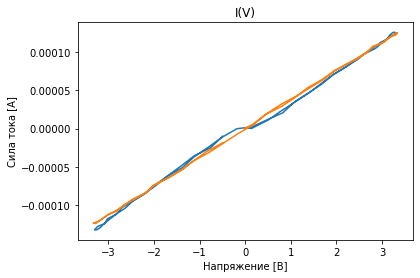

!!fail:  [27.66877969 23.3888347   5.79976681] -> 5.021124072664265 DR_DR_R detected like R
FAIL:


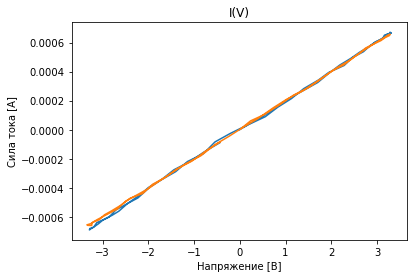

!!fail:  [77.5090127  46.22109082 16.34788736] -> [ 2.47584146 12.52925087] DR_DR_R detected like DR_R
success: [76.31383197 99.65413432 58.40760825] -> [70.82837025 92.99264456 64.93532501] circuit DR_DR_R
success: [72.57929485  6.72684857 56.99909998] -> [64.70547122  6.20748968 75.03633221] circuit DR_DR_R
success: [59.17564362 73.37731911 50.42897586] -> [60.82788268 81.06528921 54.06810935] circuit DR_DR_R
!!fail:  [54.89614836  6.74633191 89.54300376] -> [32.2081138   6.23718746] DR_DR_R detected like DR_DR
!!fail:  [50.55288652 83.29978428 35.03573444] -> [23.72182192 27.81028606] DR_DR_R detected like R_C
success: [51.28223774 42.73629716 66.48453609] -> [59.41707509 42.91660209 66.4888793 ] circuit DR_DR_R
success: [28.32692136 11.35257537 20.34134047] -> [48.14827314  9.88472563 20.66748642] circuit DR_DR_R
!!fail:  [ 6.0371208  52.8402214  41.86551473] -> [28.19250696  5.77542585] DR_DR_R detected like DR_R
!!fail:  [52.17919807 95.78635077  1.27946174] -> 1.4590604039707453

In [16]:
cre = CircuitPredictor()
cre.test_me()